In [1]:
import numpy as np
import scipy
import numpy as np
import scipy.spatial.distance as dist
import scipy.sparse as sps
import gc
import sklearn.metrics as sk
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsl
import sys
sys.path.insert(1, '/project2/dinner/jstrahan/jstrahan/DGA_src/')
import DGA_Github as DGA
List=np.load('/scratch/midway2/jstrahan/DihedralDataNew_full.npz')
List=list(np.array(List['arr_0'][0::1]))
CVList=list(np.array(np.load('/scratch/midway2/jstrahan/AllCVNew_full.npz')['arr_0'][0::1]))
print(len(List))
ntraj=len(CVList)
lenTraj=len(CVList[0])

1024


In [2]:
import sklearn.metrics as sk
Step=1
lenTraj=len(CVList[0])
ntraj=len(CVList)
CV=np.concatenate([np.concatenate(CVList)])
InA=np.zeros(len(CV))
InB=np.zeros(len(CV))
p=2
InEllipseA=(np.abs(CV[:,2]-.3)**p)/(.17**p)+(np.abs(CV[:,6]-.3)**p)/(.2**p)<1
aind=np.where(np.logical_and(InEllipseA,CV[:,3]<17))[0].astype(int)
p=3
InEllipseB=(np.abs(CV[:,2]-2.15)**p)/(.2**p)+(np.abs(CV[:,6]-2.8)**p)/(.5**p)<1
bind=np.where(InEllipseB)[0]
InA[aind]=1
InB[bind]=1
InD=1-InA-InB
FullList=np.concatenate([np.concatenate(List)])
Bpts=FullList[np.where(InB==1)[0]]
Apts=FullList[np.where(InA==1)[0]]
DistA=sk.pairwise_distances_argmin_min(FullList,Apts[0::500])[1]
DistB=sk.pairwise_distances_argmin_min(FullList,Bpts[0::500])[1]

In [3]:
def svd_whiten(X,n,frac_retain=1):
    U,L,V=np.linalg.svd(X,full_matrices=False)
    s=np.cumsum(L)/np.sum(L)
    n=np.where(s>=frac_retain)[0][0]
    return (U@V)[:,0:n],L

In [4]:
smoothingFxn=(np.power(DistB*DistA,.5)/(DistA+DistB))**2
GuessF=(DistB/(DistA+DistB))**2
GuessUF=(DistA/(DistA+DistB))**2
smoothingFxn[aind]=0
smoothingFxn[bind]=0
GuessF[aind]=1
GuessF[bind]=0
GuessUF[aind]=0
GuessUF[bind]=1
BasisF=np.concatenate(List)*smoothingFxn[:,np.newaxis]
BasisF,vals=svd_whiten(BasisF,153,frac_retain=1-1e-6)
N=len(BasisF[:,0])
nfxn=len(BasisF[0,:])
BasisF=list(BasisF.reshape((ntraj,lenTraj,nfxn)))
GuessF=list(GuessF.reshape((ntraj,lenTraj)))
GuessUF=list(GuessUF.reshape((ntraj,lenTraj)))

In [5]:
#Make q+,q-,MFPT,Change of Measure for each lag time.
import gc
import sys
sys.path.insert(1, '/project2/dinner/jstrahan/jstrahan/DGA_src/')
import importlib
importlib.reload(DGA)
#lags=[100,250,500,1000,1500,2500]
lags=[100]
QIndsFold=[]
QbIndsFold=[]
QIndsUnfold=[]
QbIndsUnfold=[]
COMInds=[]
h=True
InD=list(InD.reshape(ntraj,lenTraj))
BasisL=[]
for traj,B in zip(List,List):
    BasisL.append(np.hstack([np.ones_like(traj[:,0])[:,np.newaxis],traj])) 
for i,LagTime in enumerate(lags):
    com=DGA.changeOfMeasure_list_noeig(BasisL,LagTime)
    COMInds.append(com)
del BasisL
gc.collect()
for i,LagTime in enumerate(lags):
    QIndsUnfold.append(DGA.ForwardFK(BasisF,GuessUF,LagTime,Halt=h,InD=InD))
    qb=DGA.BackwardFK(BasisF,list(np.array(GuessF)),LagTime,Halt=h,InD=InD,COM=COMInds[i])
    QbIndsUnfold.append(qb)
    QIndsFold.append(DGA.ForwardFK(BasisF,GuessF,LagTime,Halt=h,InD=InD))
    qb=DGA.BackwardFK(BasisF,list(np.array(GuessUF)),LagTime,Halt=h,InD=InD,COM=COMInds[i])
    QbIndsFold.append(qb)
    print(LagTime)
gc.collect()

(6041600, 152)
Mem Usage= 47.060475904 Gb
38.83010353482588
52.2450512422511
(6041600, 152)
Mem Usage= 47.06084864 Gb
38.83010353482588
52.2450512422511
100


0

In [6]:
importlib.reload(DGA)
proj=[2,6]
RMSDs=list(np.array(CVList)[:,:,(proj[0],proj[1])])
gd_flux=15
gd=50
n=0
cv_names=['','Full RMSD','Alpha Helix RMSD','End-To-End Distance','','','3-10 Helix RMSD','Radius of Gyration']
xlim=np.linspace(0,np.max(np.concatenate(CVList)[:,proj[0]]),gd)
ylim=np.linspace(0,np.max(np.concatenate(CVList)[:,proj[1]]),gd)
xlim_flux=np.linspace(.2,2.6,gd_flux)
ylim_flux=np.linspace(.2,3.4,gd_flux)

Prob_plot=pmf=DGA.PMF_grid(list(np.array(CVList)[:,:,proj[0]]),list(np.array(CVList)[:,:,proj[1]]),
                   COMInds[0],xlim,ylim,lags[0])
J_is=DGA.Flux_Final(list(np.array(CVList)[:,:,proj[0]]),list(np.array(CVList)[:,:,proj[1]]),QIndsFold[0],QbIndsFold[0],
                               COMInds[n],InD,xlim_flux,ylim_flux,lag=lags[n],Backward=True)

(50, 50)
(15, 15)


In [7]:
theta=np.linspace(0,np.pi*2,500)
EllipseAX=np.sqrt(.0289)*np.cos(theta)+.3
EllipseAY=np.sqrt(.04)*np.sin(theta)+.3

EllipseBX=.2*np.power(np.abs(np.cos(theta)),2/3)*np.sign(np.cos(theta))+2.15
EllipseBY=.5*np.power(np.abs(np.sin(theta)),2/3)*np.sign(np.sin(theta))+2.8

/home/jstrahan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(50, 50)


/project2/dinner/jstrahan/jstrahan/DGA_src/DGA_Github.py:238: RuntimeWarning: invalid value encountered in double_scalars
  pmf[x,y]=np.sum(q[inds]*COM[inds])/np.sum(COM[inds])
No handles with labels found to put in legend.
/home/jstrahan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['bold'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


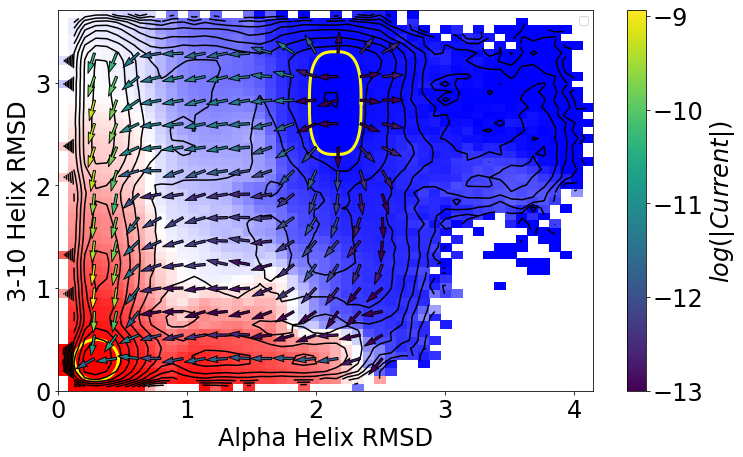

In [8]:
import matplotlib
import matplotlib.patches as patches
font = {'family' : 'bold',
        'size'   : 24}
#lags=[20,20,20,20,20,20,20,20,20,20]
matplotlib.rc('font', **font)
P=(-np.log(Prob_plot.T)-np.min(-(np.log(Prob_plot.flatten()))[np.isfinite(np.log(Prob_plot.flatten()))]))
JAB=(J_is)
Len=np.sqrt(np.sum(JAB**2,axis=0))
JAB=JAB/Len
fig = plt.figure(figsize=(12,7))
ax=plt.subplot(111)
avg=DGA.avg_on_pmf_dga(list(np.array(CVList)[:,:,proj[0]]),list(np.array(CVList)[:,:,proj[1]]),
                      np.asarray(QIndsFold[0]),COMInds[0],xlim,ylim,lags[0])
Skip=1
evels=np.array([0,.01,.02,.05,.1,.3,.5,.7,.8,.9,1])
X,Y=np.meshgrid(xlim,ylim) 
s=ax.pcolor(X,Y,avg.T,cmap='bwr',zorder=0)
centerx =(xlim[1:]+xlim[:-1])/2
centery =(ylim[1:]+ylim[:-1])/2
centerx_flux =(xlim_flux[1:]+xlim_flux[:-1])/2
centery_flux =(ylim_flux[1:]+ylim_flux[:-1])/2
X,Y=np.meshgrid(centerx_flux,centery_flux)
ax.contour(centerx,centery,P,colors='black',levels=range(0,13,1),zorder=5)

#q=ax.quiver(X[0::Skip,0::Skip],Y[0::Skip,0::Skip],JAB[0].T[0::Skip,0::Skip],
#            JAB[1].T[0::Skip,0::Skip],linewidths=1,zorder=10)
q=ax.quiver(X[0::Skip,0::Skip],Y[0::Skip,0::Skip],JAB[0].T[0::Skip,0::Skip],
            JAB[1].T[0::Skip,0::Skip],np.log(Len).T[0::Skip,0::Skip],linewidths=.9,zorder=15)
q.set_clim(vmin=-13)
q.set_edgecolor('black')
ax.plot(EllipseAX,EllipseAY,linewidth=3,color='yellow')
ax.plot(EllipseBX,EllipseBY,linewidth=3,color='yellow')
c=fig.colorbar(q,ax=ax)
c.set_label('$log(|Current|)$')
#c=fig.colorbar(s,ax=ax)
#c.set_label('$Committor$')
#plt.title('Tica Indicators DGA Folding Reactive Current')
ax.legend(prop={'size': 11})
ax.set_xlabel(cv_names[proj[0]])
ax.set_ylabel(cv_names[proj[1]])
rect = patches.Rectangle((4.012,.6),.4,.25,linewidth=3,edgecolor='black',facecolor='none')
# Add the patch to the Axes
#ax.add_patch(rect)
circ = patches.Ellipse((2.52,1.58),.4,.25,linewidth=3,edgecolor='black',facecolor='none')

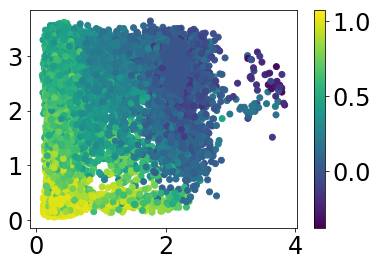

In [10]:
plt.scatter(np.array(CVList)[:,:,proj[0]].flatten()[0::100],np.array(CVList)[:,:,proj[1]].flatten()[0::100],c=np.asarray(QIndsFold[0]).flatten()[0::100])
plt.colorbar()